<a href="https://colab.research.google.com/github/tanucsengg/Deep-Learning/blob/main/03_Predict_Fuel_Efficiency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Table of Content

1. [Predict Fuel Efficiency Overview](#section1)<br>
2. [The Auto MPG Dataset](#section2)<br>
  - 2.1 [Get the Data](#section201)<br>
  - 2.2 [Clean the Data](#section202)<br>
  - 2.3 [Split the Data into Train and Test](#section203)<br>
  - 2.4 [Inspect the Data](#section204)<br>
  - 2.5 [Split Features from Labels](#section205)<br>
  - 2.6 [Normalize the Data](#section206)<br>
3. [The Model](#section3)<br>
  - 3.1 [Build the Model](#section301)<br>
  - 3.2 [Inspect the Model](#section302)<br>
  - 3.3 [Train the Model](#section303)<br>
  - 3.4 [Make Predictions](#section304)<br>
4. [Model Tuning](#section4)<br>
  - 4.1 [Increasing the Number of Hidden Layers and Hidden Units](#section401)<br>
  - 4.2 [Weight Regularization](#section402)<br>
  - 4.3 [Dropout](#section403)<br>
  - 4.4 [Combined L2 + Dropout](#section404)<br>
  - 4.5 [Batch Normalization](#section405)<br>
5. [Conclusion](#section5)<br>

<a id=section1></a>
## 1. Predict Fuel Efficiency Overview

- We will use the [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) Dataset and build a model to predict the fuel efficiency of late-1970s and early 1980s automobiles.

- To do this, we'll provide the model with a description of many automobiles from that time period.

  - This description includes attributes like: cylinders, displacement, horsepower, and weight.

<center><img src="https://raw.githubusercontent.com/insaid2018/DeepLearning/master/images/fuel-efficiency.png" width="500" /></center>

In [ ]:
# To use some functions from tensorflow_docs
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-d71iltz3
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-d71iltz3
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.03dca32f59ff76a1fed82f5e799a4dc38e498b7c6_-cp36-none-any.whl size=139262 sha256=d1563ebba2eb900e475dee2a9a19707b80b31771289d7025f8cb2ab6b8633b66
  Stored in directory: /tmp/pip-ephem-wheel-cache-ab3ydbtm/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [ ]:
import pathlib

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [ ]:
# Import tensorflow 2.x
# This code block will only work in Google Colab.
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.3.0


In [ ]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

<a id=section2></a>
## 2. The Auto MPG Dataset

The dataset is available on the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/).


<a id=section201></a>
### 2.1 Get the Data

- First download the dataset.

In [ ]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

32768/30286 [================================] - 0s 1us/step


'/root/.keras/datasets/auto-mpg.data'

- Import it using pandas.

In [ ]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight', 'Acceleration', 'Model Year', 'Origin']

In [ ]:
dataset = pd.read_csv(dataset_path, names=column_names, na_values="?", comment='\t', sep=" ", skipinitialspace=True)
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


- The data concerns city-cycle fuel consumption in **miles per gallon**, to be predicted in terms of **3 multivalued discrete** and **4 continuous** attributes.

<a id=section202></a>
### 2.2 Clean the Data

- The dataset contains a few unknown values.

In [ ]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

- Dropping these rows.

In [ ]:
dataset = dataset.dropna()

- The `"Origin"` column is categorical, not numeric.

- Converting that to a one-hot:

In [ ]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [ ]:
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


<a id=section203></a>
### 2.3 Split the Data into Train and Test

- Now we will split the dataset into a training set and a test set.

- We will use the test set in the final evaluation of our model.

In [ ]:
train_dataset = dataset.sample(frac=0.8,random_state=0)

In [ ]:
test_dataset = dataset.drop(train_dataset.index)

<a id=section204></a>
### 2.4 Inspect the Data

- We will have a quick look at the joint distribution of a few pairs of columns from the training set.

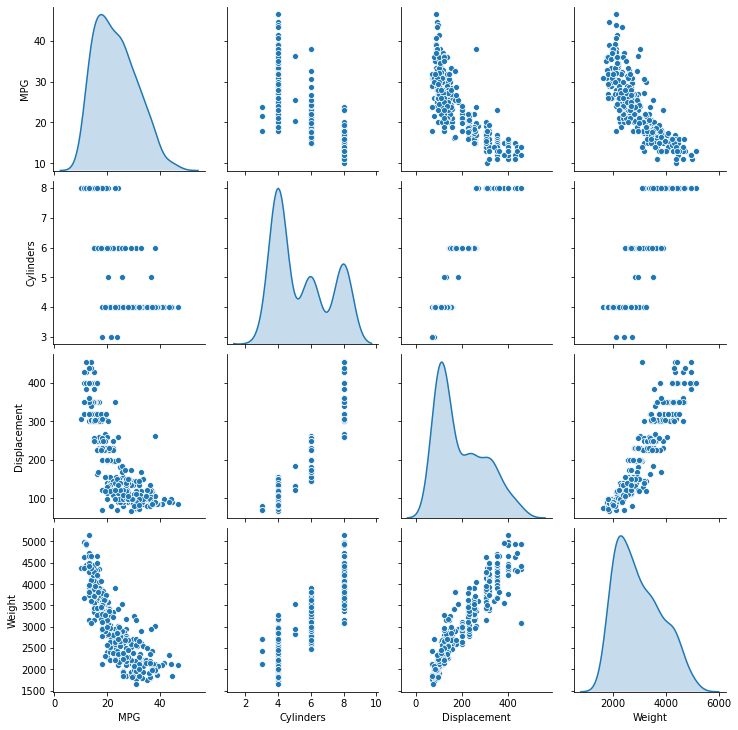

In [ ]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

- Let's also look at the overall statistics:

In [ ]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


<a id=section205></a>
### 2.5 Split Features from Labels

- Separate the target value, or "label", from the features.

- This label is the value that we will train the model to predict.

In [ ]:
train_labels = train_dataset.pop('MPG')

In [ ]:
test_labels = test_dataset.pop('MPG')

<a id=section206></a>
### 2.6 Normalize the Data

- Look again at the `train_stats` block above and note how different the ranges of each feature are.

- It is good practice to normalize features that use different scales and ranges.

- Although the model *might* converge without feature normalization, it makes training more difficult, and it makes the resulting model dependent on the choice of units used in the input.

- **Note**: Although we intentionally generate these statistics from only the training dataset, these statistics will also be used to normalize the test dataset.

  - We need to do that to project the test dataset into the same distribution that the model has been trained on.

In [ ]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

In [ ]:
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

- This normalized data is what we will use to train the model.

- **Caution**: The statistics used to normalize the inputs here (mean and standard deviation) need to be applied to any other data that is fed to the model, along with the one-hot encoding that we did earlier.

  - That includes the test set as well as live data when the model is used in production.

<a id=section3></a>
## 3. The Model

<a id=section301></a>
### 3.1 Build the Model

- Let's build our model.

- Here, we'll use a `Sequential` model with two densely connected hidden layers, and an output layer that returns a single, continuous value.
  
  - Previously, we use the `model.add()` method to **add layers** to our sequential model.

  - Here, we will directly **pass** all our *model layers* as **list items**.

  - We achive same result in both ways.

- The model building steps are wrapped in a function, `build_model`, since we'll create a second model, later on.

In [ ]:
def build_model():
  model = keras.Sequential([layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
                            layers.Dense(64, activation='relu'),
                            layers.Dense(1)])

  # Defining the optimizer with a specific learning rate of 0.001
  optimizer = tf.keras.optimizers.RMSprop(0.001)

  # Compiling the model
  model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
  return model

In [ ]:
model = build_model()

<a id=section302></a>
### 3.2 Inspect the Model

- Using the `.summary` method to print a simple description of the model

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


- Now let's try out the model.

- Taking a batch of `10` examples from the training data and calling `model.predict` on it.

In [ ]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[0.48484805],
       [0.4355578 ],
       [0.212417  ],
       [0.7041454 ],
       [0.60287637],
       [0.6091177 ],
       [0.5872176 ],
       [0.31597763],
       [0.42067105],
       [0.3166316 ]], dtype=float32)

- It seems to be working, and it produces a result of the expected shape and type.

- We haven't trained the model yet, and as a result the above predictions are like this. 

<a id=section303></a>
### 3.3 Train the Model

- Training the model for 1000 epochs, and recording the training and validation accuracy in the `history` object.

- We are using `tfdocs.modeling.EpochDots()` callback to print a "." every epoch, with reports after each 100 epochs.

  - These print settings are the default values, i. e. printing a "." after each epoch and a report after 100 epochs.

  - We can change these as per our requirements in the callback.

In [ ]:
EPOCHS = 1000

In [ ]:
history = model.fit(normed_train_data, train_labels, epochs=EPOCHS, validation_split=0.2,
                    verbose=0, callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:541.7487,  mae:22.0096,  mse:541.7487,  val_loss:527.7060,  val_mae:21.6704,  val_mse:527.7060,  
....................................................................................................
Epoch: 100, loss:5.9830,  mae:1.7128,  mse:5.9830,  val_loss:7.8288,  val_mae:2.1707,  val_mse:7.8288,  
....................................................................................................
Epoch: 200, loss:5.1332,  mae:1.5653,  mse:5.1332,  val_loss:8.1362,  val_mae:2.2020,  val_mse:8.1362,  
....................................................................................................
Epoch: 300, loss:4.9049,  mae:1.4785,  mse:4.9049,  val_loss:8.0897,  val_mae:2.1635,  val_mse:8.0897,  
....................................................................................................
Epoch: 400, loss:4.3985,  mae:1.4215,  mse:4.3985,  val_loss:8.0632,  val_mae:2.1577,  val_mse:8.0632,  
..............................................................

- Visualizing the model's training progress using the stats stored in the `history` object.

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.618519,0.993956,2.618519,9.135721,2.311579,9.135721,995
996,2.668238,1.049185,2.668238,8.419825,2.246917,8.419825,996
997,2.758652,1.048263,2.758652,9.756766,2.355290,9.756766,997
998,2.595248,1.018901,2.595248,8.953794,2.299003,8.953794,998
999,2.501513,1.001177,2.501513,9.032974,2.275855,9.032974,999


- We are using `tfdocs.plots.HistoryPlotter()` to plot our model history.


In [ ]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

- Specifying the name of our **history** object in the `plotter.plot()` method.

- We also need to specify the **metric** we want to plot.

- Plotting the **MAE** plot for train and val set.

Text(0, 0.5, 'MAE [MPG]')

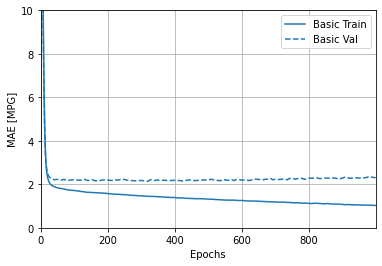

In [ ]:
plotter.plot({'Basic': history}, metric="mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

- Plotting the **MSE** plot for train and val set.

Text(0, 0.5, 'MSE [MPG^2]')

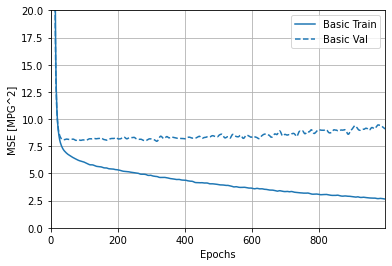

In [ ]:
plotter.plot({'Basic': history}, metric="mse")
plt.ylim([0, 20])
plt.ylabel('MSE [MPG^2]')

- This graph shows little improvement, or even degradation in the validation error after about 100 epochs.

- Let's update the `model.fit` call to automatically stop training when the validation score doesn't improve.

- We'll use an *EarlyStopping callback* that tests a training condition for  every epoch.

  - If a set amount of epochs elapses without showing improvement, then automatically stop the training.

In [ ]:
model = build_model()

In [ ]:
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
early_history = model.fit(normed_train_data, train_labels, epochs=EPOCHS, validation_split=0.2,
                          verbose=0, callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:569.3649,  mae:22.5323,  mse:569.3649,  val_loss:562.8590,  val_mae:22.3140,  val_mse:562.8590,  
..............................................................................

In [ ]:
early_hist = pd.DataFrame(early_history.history)
early_hist['epoch'] = early_history.epoch
early_hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
73,6.250001,1.740645,6.250001,8.534706,2.145968,8.534706,73
74,6.333835,1.780969,6.333835,8.317598,2.217719,8.317598,74
75,6.153298,1.719246,6.153298,8.284129,2.144915,8.284129,75
76,6.295592,1.743015,6.295592,8.369061,2.195892,8.369061,76
77,6.240103,1.750755,6.240103,8.192513,2.151584,8.192513,77


- The training stopped before completing the 1000 epochs due to our EarlyStopping callback.

Text(0, 0.5, 'MAE [MPG]')

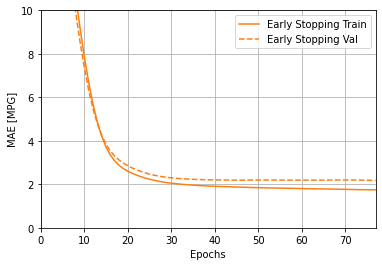

In [ ]:
plotter.plot({'Early Stopping': early_history}, metric="mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

- The graph shows that on the validation set, the average error is usually around **+/- 2 MPG**.

- Is this good? We'll leave that decision up to you.

- Let's see how well the model generalizes by using the **test** set, which we did not use when training the model.

- This tells us how well we can expect the model to predict when we use it in the real world.

In [ ]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 5.7151 - mae: 1.8517 - mse: 5.7151
Testing set Mean Abs Error:  1.85 MPG


- We get a MAE of **less than 2 MPG** on the test set.

<a id=section304></a>
### 3.4 Make Predictions

- Finally, **predict MPG** values using data in the testing set:

In [ ]:
test_predictions = model.predict(normed_test_data).flatten()

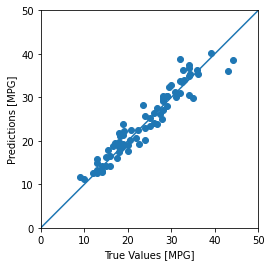

In [ ]:
a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

- It looks like our model predicts reasonably well.

- Let's take a look at the **error** distribution.

In [ ]:
error = test_predictions - test_labels

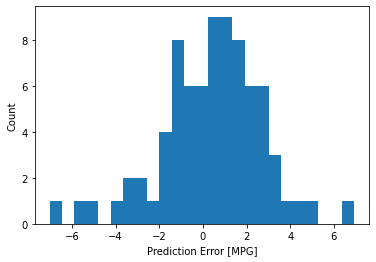

In [ ]:
plt.hist(error, bins=25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

- It's not quite gaussian, but we might expect that because the number of samples is very small.

<a id=section4></a>
## 4. Model Tuning

- We have already achieved very good result on our test set.

- If we train the model for too long, the model will start to overfit and learn patterns from the training data that don't generalize to the test data.

  - We need to strike a balance.
  
  - We have already learned how to train for an appropriate number of epochs using the **Early Stopping** callback.

- And, now we will experiment some additional methods to **improve** the model **performance** and reduce overfitting.

  - These methods will all be applied during model building.

<a id=section401></a>
### 4.1 Increasing the Number of Hidden Layers and Hidden Units

- We can improve model performance by increasing the number of hidden layers and hidden units in the model.

  - But this can result in overfitting.

- Here, we are increasing the number of **hidden layers** from 2 to **4** i. e. adding 2 additional layers.

- Next, we are using **256 hidden units** instead of 64.

In [ ]:
model = keras.Sequential([layers.Dense(256, activation='relu', input_shape=[len(train_dataset.keys())]),
                          layers.Dense(256, activation='relu'),
                          layers.Dense(256, activation='relu'),
                          layers.Dense(256, activation='relu'),
                          layers.Dense(1)])

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 256)               2560      
_________________________________________________________________
dense_17 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_18 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_19 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 257       
Total params: 200,193
Trainable params: 200,193
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Defining the optimizer with a specific learning rate of 0.001
optimizer = tf.keras.optimizers.RMSprop(0.001)

# Compiling the model
model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])

- We are not using the Early Stopping callback now.

- The model will be trained for **100 epochs**.

In [ ]:
history_large = model.fit(normed_train_data, train_labels, epochs=100, validation_split=0.2,
                          verbose=0, callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:251.6537,  mae:12.9217,  mse:251.6537,  val_loss:57.0975,  val_mae:6.6906,  val_mse:57.0975,  
....................................................................................................

In [ ]:
hist_large = pd.DataFrame(history_large.history)
hist_large['epoch'] = history_large.epoch
hist_large.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
95,11.251785,2.593729,11.251785,9.127599,2.236834,9.127599,95
96,5.190663,1.587650,5.190663,14.745302,3.209125,14.745302,96
97,9.112062,2.205664,9.112062,23.110064,4.130605,23.110064,97
98,7.514537,1.994598,7.514537,8.975740,2.377245,8.975740,98
99,7.112574,1.908518,7.112574,16.578730,3.476238,16.578730,99


Text(0, 0.5, 'MAE [MPG]')

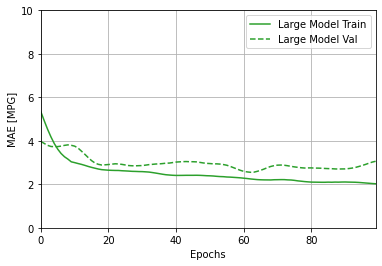

In [ ]:
plotter.plot({'Large Model': history_large}, metric="mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

In [ ]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 12.0076 - mae: 2.7568 - mse: 12.0076
Testing set Mean Abs Error:  2.76 MPG


- We get a significant increase in the test set error.

- The larger model is **overfitting** the train set.

- The performance on the test set is worse than our smaller model.

<a id=section402></a>
### 4.2 Weight Regularization

- Regularization places **constraints** on the quantity and type of information the model can store.

- If a network can only afford to memorize a small number of patterns, the optimization process will force it to focus on the most prominent patterns, which have a better chance of generalizing well.

- We can put constraints on the complexity of a network by forcing its weights only to take small values, which makes the distribution of weight values more "regular".

- This is called "**weight regularization**", and it is done by adding to the loss function of the network a cost associated with having large weights.

- This cost comes in two flavors:

  - L1 regularization, where the cost added is proportional to the absolute value of the weights coefficients (i.e. to what is called the "L1 norm" of the weights).

  - L2 regularization, where the cost added is proportional to the square of the value of the weights coefficients (i.e. to what is called the squared "L2 norm" of the weights).
    - L2 regularization is also called weight decay in the context of neural networks.
    
    - Don't let the different name confuse you: weight decay is mathematically the exact same as L2 regularization.

- L1 regularization pushes weights towards exactly zero encouraging a sparse model.

- L2 regularization will penalize the weights parameters without making them sparse since the penalty goes to zero for small weights.

  - One reason why L2 is more common.

- In `tf.keras`, weight regularization is added by passing weight regularizer instances to layers as keyword arguments.

- Let's add L2 weight regularization to the model.

In [ ]:
from tensorflow.keras import regularizers

In [ ]:
model = keras.Sequential([layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=[len(train_dataset.keys())]),
                          layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
                          layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
                          layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
                          layers.Dense(1)])

- `l2(0.001)` means that every coefficient in the weight matrix of the layer will add `(0.001 * weight_coefficient_value**2)` to the total loss of the network.

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 256)               2560      
_________________________________________________________________
dense_22 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_23 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_24 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 257       
Total params: 200,193
Trainable params: 200,193
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Defining the optimizer with a specific learning rate of 0.001
optimizer = tf.keras.optimizers.RMSprop(0.001)

# Compiling the model
model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])

In [ ]:
history_l2 = model.fit(normed_train_data, train_labels, epochs=100, validation_split=0.2,
                          verbose=0, callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:11.1039,  mae:2.4910,  mse:10.7133,  val_loss:23.6028,  val_mae:4.1313,  val_mse:23.2143,  
....................................................................................................

In [ ]:
hist_l2 = pd.DataFrame(history_l2.history)
hist_l2['epoch'] = history_l2.epoch
hist_l2.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
95,5.571243,1.700577,5.219910,10.070971,2.449507,9.719448,95
96,3.707268,1.387418,3.356185,8.279347,2.263838,7.928108,96
97,9.306983,2.121928,8.956490,9.085012,2.167993,8.735017,97
98,3.336779,1.208559,2.987214,9.899775,2.469251,9.550734,98
99,4.304240,1.428926,3.954619,11.663343,2.628310,11.314541,99


Text(0, 0.5, 'MAE [MPG]')

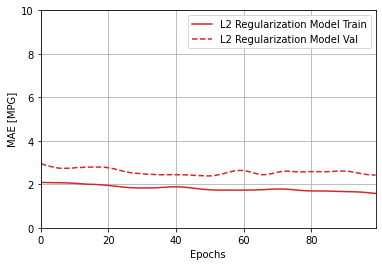

In [ ]:
plotter.plot({'L2 Regularization Model': history_l2}, metric="mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

In [ ]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 7.9875 - mae: 1.9758 - mse: 7.6387
Testing set Mean Abs Error:  1.98 MPG


- After adding L2 regularization, the test set error is reduced.

- The performance on the test set is better than the larger model.

- The L2 regularized model is much more resistant to overfitting than the larger model.

<a id=section403></a>
### 4.3 Dropout

- Dropout is one of the **most effective** and **most commonly used** regularization techniques for neural networks, developed by Hinton and his students at the University of Toronto.

- The intuitive explanation for dropout is that because individual nodes in the network cannot rely on the output of the others, each node must output features that are useful on their own.

- Dropout, applied to a layer, consists of **randomly** "**dropping out**" (i.e. set to zero) a number of **output features** of the layer during training.

  - Let's say a given layer would normally have returned a vector [0.2, 0.5, 1.3, 0.8, 1.1] for a given input sample during training.
  
  - After applying dropout, this vector will have a few zero entries distributed at random, e.g. [0, 0.5, 1.3, 0, 1.1].

- The "**dropout rate**" is the fraction of the features that are being zeroed-out; it is usually set between **0.2** and **0.5**.

- *At test time*, **no units are dropped out**, and instead the layer's output values are scaled down by a factor equal to the dropout rate, so as to balance for the fact that more units are active than at training time.

- In `tf.keras` we can introduce dropout in a network via the Dropout layer, which gets applied to the output of layer right before.

- Let's add Dropout layers in our network to see how well they do at reducing overfitting.

In [ ]:
model = keras.Sequential([layers.Dense(256, activation='relu', input_shape=[len(train_dataset.keys())]),
                          layers.Dropout(0.2),
                          layers.Dense(256, activation='relu'),
                          layers.Dropout(0.2),
                          layers.Dense(256, activation='relu'),
                          layers.Dropout(0.2),
                          layers.Dense(256, activation='relu'),
                          layers.Dropout(0.2),
                          layers.Dense(1)])

In [ ]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 256)               2560      
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_13 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 256)              

In [ ]:
# Defining the optimizer with a specific learning rate of 0.001
optimizer = tf.keras.optimizers.RMSprop(0.001)

# Compiling the model
model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])

In [ ]:
history_dropout = model.fit(normed_train_data, train_labels, epochs=100, validation_split=0.2,
                          verbose=0, callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:261.3717,  mae:13.0148,  mse:261.3717,  val_loss:54.9459,  val_mae:6.3947,  val_mse:54.9459,  
....................................................................................................

In [ ]:
hist_dropout = pd.DataFrame(history_dropout.history)
hist_dropout['epoch'] = history_dropout.epoch
hist_dropout.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
95,13.371156,2.731506,13.371156,7.435190,2.051282,7.435190,95
96,13.004848,2.745411,13.004848,12.350990,2.829050,12.350990,96
97,19.540569,3.169657,19.540569,8.843312,2.356980,8.843312,97
98,11.717366,2.400953,11.717366,8.594843,2.332206,8.594843,98
99,17.138292,3.000023,17.138292,10.042668,2.420357,10.042668,99


Text(0, 0.5, 'MAE [MPG]')

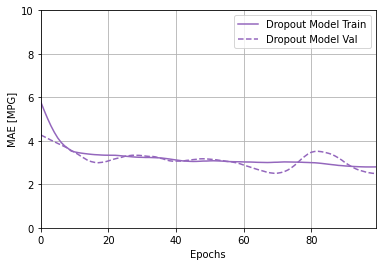

In [ ]:
plotter.plot({'Dropout Model': history_dropout}, metric="mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

In [ ]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 7.5419 - mae: 1.9651 - mse: 7.5419
Testing set Mean Abs Error:  1.97 MPG


- After adding the dropout the model is generalizing well on the test set.

- The performance is better than the larger model.

<a id=section404></a>
### 4.4 Combined L2 + Dropout

- We can also combine both L2 regularization and Dropout in a single model.

In [ ]:
from tensorflow.keras import regularizers

In [ ]:
model = keras.Sequential([layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=[len(train_dataset.keys())]),
                          layers.Dropout(0.2),
                          layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
                          layers.Dropout(0.2),
                          layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
                          layers.Dropout(0.2),
                          layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
                          layers.Dropout(0.2),
                          layers.Dense(1)])

In [ ]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 256)               2560      
_________________________________________________________________
dropout_16 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_47 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_17 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_18 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 256)             

In [ ]:
# Defining the optimizer with a specific learning rate of 0.001
optimizer = tf.keras.optimizers.RMSprop(0.001)

# Compiling the model
model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])

In [ ]:
history_l2_dropout = model.fit(normed_train_data, train_labels, epochs=100, validation_split=0.2,
                          verbose=0, callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:277.3260,  mae:13.4767,  mse:276.5412,  val_loss:36.1759,  val_mae:5.0721,  val_mse:35.3930,  
....................................................................................................

In [ ]:
hist_l2_dropout = pd.DataFrame(history_l2_dropout.history)
hist_l2_dropout['epoch'] = history_l2_dropout.epoch
hist_l2_dropout.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
95,14.519838,2.846194,13.993567,9.188333,2.283489,8.662151,95
96,17.737673,3.080981,17.212132,12.083693,2.581887,11.556751,96
97,14.831047,2.697509,14.305573,13.342816,2.588649,12.815903,97
98,14.178879,2.727585,13.653602,16.383785,3.271129,15.859987,98
99,19.197338,3.273074,18.672829,9.406791,2.448029,8.882733,99


Text(0, 0.5, 'MAE [MPG]')

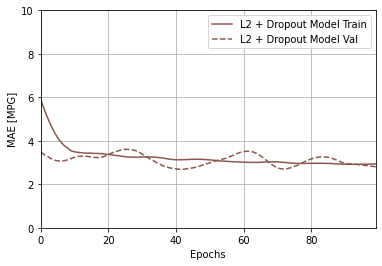

In [ ]:
plotter.plot({'L2 + Dropout Model': history_l2_dropout}, metric="mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

In [ ]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 7.1532 - mae: 2.0314 - mse: 6.6292
Testing set Mean Abs Error:  2.03 MPG


- The combined L2 + Dropout model is also outperforming the larger model.

- We can attain a better score if we apply the Early Stopping callback to this model.

<a id=section405></a>
### 4.5 Batch Normalization

- Batch normalization is a technique for training very deep neural networks.

    - It **normalizes** the **activations** of the previous layer at each batch.

    - It applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1.

- This has the effect of stabilizing the learning process and dramatically reducing the number of training epochs required to train deep networks.

- Batch normalization may be used on the inputs to the layer before or after the activation function in the previous layer.

- It may be more appropriate **after** the activation function for **s-shaped** functions like the **hyperbolic tangent** and **logistic** function.

- It may be more appropriate **before** the activation function for activations that may result in **non-Gaussian** distributions like the **rectified linear** activation function, the modern default for most network types.

- Since we are using **ReLU** activation function in our model, we will use the Batch Normalization layer **prior** to the ReLU layer.

In [ ]:
model = keras.Sequential([layers.Dense(256, input_shape=[len(train_dataset.keys())]),
                          layers.BatchNormalization(),
                          layers.ReLU(),
                          layers.Dense(256),
                          layers.BatchNormalization(),
                          layers.ReLU(),
                          layers.Dense(256),
                          layers.BatchNormalization(),
                          layers.ReLU(),
                          layers.Dense(256),
                          layers.BatchNormalization(),
                          layers.ReLU(),
                          layers.Dense(1)])

In [ ]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_61 (Dense)             (None, 256)               2560      
_________________________________________________________________
batch_normalization_6 (Batch (None, 256)               1024      
_________________________________________________________________
re_lu (ReLU)                 (None, 256)               0         
_________________________________________________________________
dense_62 (Dense)             (None, 256)               65792     
_________________________________________________________________
batch_normalization_7 (Batch (None, 256)               1024      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 256)               0         
_________________________________________________________________
dense_63 (Dense)             (None, 256)             

In [ ]:
# Defining the optimizer with a specific learning rate of 0.001
optimizer = tf.keras.optimizers.RMSprop(0.001)

# Compiling the model
model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])

In [ ]:
history_batch_norm = model.fit(normed_train_data, train_labels, epochs=100, validation_split=0.2,
                          verbose=0, callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:512.3126,  mae:22.0897,  mse:512.3126,  val_loss:583.1364,  val_mae:23.1268,  val_mse:583.1364,  
....................................................................................................

In [ ]:
hist_batch_norm = pd.DataFrame(history_batch_norm.history)
hist_batch_norm['epoch'] = history_batch_norm.epoch
hist_batch_norm.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
95,5.870254,1.805393,5.870254,7.480476,2.097130,7.480476,95
96,5.060385,1.709868,5.060385,8.596467,2.329535,8.596467,96
97,6.858043,1.952120,6.858043,10.327602,2.490928,10.327602,97
98,4.588964,1.554204,4.588964,8.605907,2.297268,8.605907,98
99,5.059868,1.620360,5.059868,7.256053,2.096903,7.256053,99


Text(0, 0.5, 'MAE [MPG]')

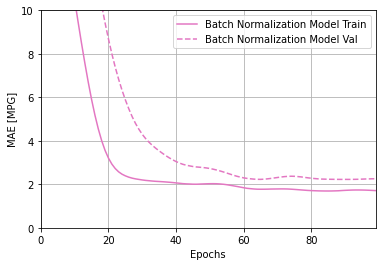

In [ ]:
plotter.plot({'Batch Normalization Model': history_batch_norm}, metric="mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

In [ ]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 4.6668 - mae: 1.6738 - mse: 4.6668
Testing set Mean Abs Error:  1.67 MPG


- The Batch Normalization model attains the **lowest test set error**.

- We have significantly **reduced** the **overfitting**.

- It is generalizing well on the test set.

- We can also incorporate the Early Stopping callback to this model to stop training at an appropriate epoch.

<a id=section5></a>
## 5. Conclusion

We studied a few techniques to handle a regression problem.

- **Mean Squared Error** (MSE) is a common loss function used for regression problems (different loss functions are used for classification problems).

- Similarly, evaluation metrics used for regression differ from classification.

  - A common regression metric is **Mean Absolute Error** (MAE).

- When numeric input data features have values with different ranges, each **feature** should be **scaled** independently to the same range.

- If there is not much training data, one technique is to prefer a **small network** with few hidden layers to avoid overfitting.

- **Early stopping** is a useful technique to prevent overfitting.

- We can improve the performance of a model by increasing the number of hidden layers and the hidden units in the model.

- Regularization Techniques to reduce overfitting are:

  - **Weight Regularization**

  - **Dropout**

  - **Batch Normalization**